In [7]:
import pandas as pd
import matplotlib.pyplot as plt

## Public transport stations for a specific area

In [10]:
from pyrosm import OSM
from pyrosm import get_data

for city in ["Zuerich"]:
    # download data for a specific city
    fp = get_data(city)
    
    # Initialize the OSM parser object
    osm = OSM(fp)

    # Filter for PT stations
    custom_filter = {
        "public_transport": ["station"],
    }
    pois = osm.get_data_by_custom_criteria(custom_filter=custom_filter, keep_ways=False, keep_relations=False)
    print("Raw POIs length", len(pois))

Raw POIs length 243


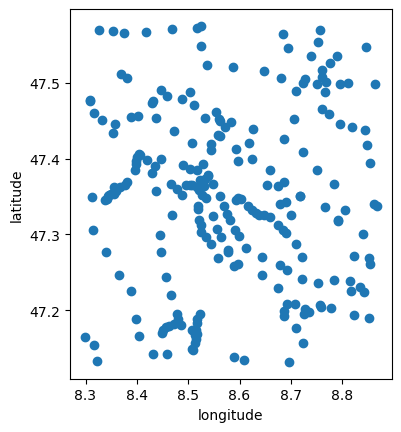

In [8]:
# plot points with geopandas
pois.plot()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

### All Public Transport stations worldwide via Overpass API

Not tested yet, probably takes forever

In [ ]:
import requests
import pandas as pd

# Overpass API endpoint
overpass_url = "http://overpass-api.de/api/interpreter"

# Overpass QL query to get public transport stations
overpass_query = """
[out:json][timeout:900];
(
  node["public_transport"="station"];
);
out center;
"""

# Send the query to the Overpass API
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

# Parse the response
elements = data['elements']

# Extract relevant information
stations = []
for elem in elements:
    station = {
        'id': elem['id'],
        'type': elem['type'],
        'lat': elem.get('lat', elem['center']['lat']),
        'lon': elem.get('lon', elem['center']['lon']),
        'tags': elem.get('tags', {})
    }
    stations.append(station)

# Convert to DataFrame
stations_df = pd.DataFrame(stations)

# Display the resulting DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="Worldwide Public Transport Stations", dataframe=stations_df)

# Optionally, you can save the DataFrame to a CSV file
stations_df.to_csv("worldwide_public_transport_stations.csv", index=False)



### Airbnb API
ChatGPT code - not tested yet

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import json

def get_airbnb_listings(location, page=1):
    url = f"https://www.airbnb.com/s/{location}/homes"
    params = {
        'items_offset': (page - 1) * 20,
        'section_offset': '0'
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Error: Unable to access {url}")
        return []
    
    soup = BeautifulSoup(response.text, 'html.parser')
    data_script = soup.find('script', {'id': 'data-deferred-state'})
    
    if not data_script:
        print("Error: Unable to find data-deferred-state script tag.")
        return []
    
    data = json.loads(data_script.string)
    listings = data.get('niobeMinimalClientData', [])[1][1]['data']['presentation']['explore']['sections']['sectionIndependentData']
    
    return listings

def parse_listings(listings):
    results = []
    for listing in listings:
        try:
            result = {
                'name': listing['listing']['name'],
                'lat': listing['listing']['lat'],
                'lng': listing['listing']['lng'],
                'city': listing['listing']['city'],
                'price': listing['pricingQuote']['rate']['amount'],
                'currency': listing['pricingQuote']['rate']['currency'],
                'url': f"https://www.airbnb.com/rooms/{listing['listing']['id']}"
            }
            results.append(result)
        except KeyError:
            continue
    return results

# Example Usage
location = "Zurich--Switzerland"  # Use location name as in Airbnb URL
all_listings = []

for page in range(1, 3):  # Adjust the range to get more pages
    listings = get_airbnb_listings(location, page)
    all_listings.extend(parse_listings(listings))
    time.sleep(2)  # Sleep to avoid rate limiting

# Convert to DataFrame
df = pd.DataFrame(all_listings)
import ace_tools as tools; tools.display_dataframe_to_user(name="Airbnb Listings", dataframe=df)

# Save to CSV
df.to_csv('airbnb_listings.csv', index=False)
